In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import statsmodels.formula.api as smf
import statsmodels.api as sm
from fit import likelihood, stat_fit_scipy
from RL2 import activity_RL
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.2)
plt.rcParams['axes.formatter.use_mathtext'] = True

#### Debug

In [ ]:
start = time.time()
model_type = "ZS"
sids = pd.read_pickle(f"data/human.pkl")['sid'].unique()
dfs = []
dfs2 = []
for sid in sids[:5]:
    print(sid)
    fitted_data, fitted_params = stat_fit_scipy(model_type, sid, save=False)
    dfs.append(fitted_data)
    dfs2.append(fitted_params)
fitted = pd.concat(dfs, ignore_index=True)
params = pd.concat(dfs2, ignore_index=True)
print(fitted)
print(params)
end = time.time()
print(f"runtime {(end-start)/60:.4} min")

In [82]:
pd.read_pickle("data/NEF_WM_1_performance.pkl")

,type,sid,NLL,McFadden R2
0,NEF_WM,1,2.488893,0.977558


## Compare NEF-WM models and Z (DeGroot) models

In [83]:
z0 = pd.read_pickle("data/Z0_Z0n_performance.pkl")
z_any = pd.read_pickle("data/Z_z_any_performance.pkl")
k_any = pd.read_pickle("data/K_k_any_performance.pkl")
zk_any = pd.read_pickle("data/ZK_any_performance.pkl")

nef_z0k1 = pd.read_pickle("data/NEF_WM_Z0K1_performance.pkl")

z0['type'] = "DG, naive"
z_any['type'] = "K=0, fit Z"
k_any['type'] = "Z=0, fit K"
zk_any['type'] = "fit Z, fit K"

nef_z0k1['type'] = "NEF-WM, naive"

combined = pd.concat([z0, z_any, k_any, zk_any], ignore_index=True)
combined_nef = pd.concat([nef_z0k1], ignore_index=True)

/tmp/ipykernel_21024/105625731.py:6: UserWarning: The palette list has more values (4) than needed (1), which may not be intended.
  sns.boxplot(combined_nef, x='type', y='NLL', hue='type', ax=axes[0], palette=palette[:4],
/tmp/ipykernel_21024/105625731.py:10: UserWarning: The palette list has more values (4) than needed (1), which may not be intended.
  sns.boxplot(combined_nef, x='type', y='McFadden R2', hue='type', ax=axes[1], palette=palette[:4],


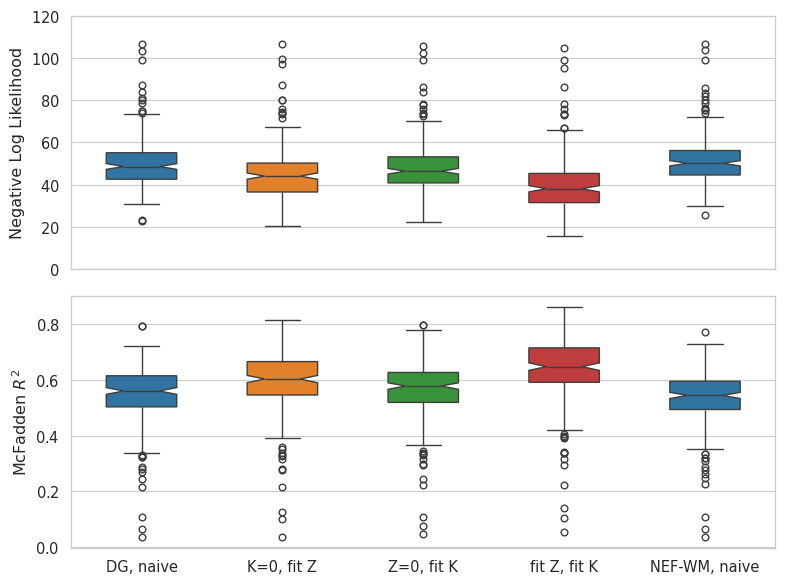

In [84]:
with sns.axes_style("whitegrid"):  # This enables gridlines
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,6), sharex=True, sharey='row')
    # mts = ["DG, naive", "DG, fit Z", "NEF-WM, naive"]
    sns.boxplot(combined, x='type', y='NLL', hue='type', ax=axes[0], palette=palette[:4],
               notch=True, width=0.5)
    sns.boxplot(combined_nef, x='type', y='NLL', hue='type', ax=axes[0], palette=palette[:4],
               notch=True, width=0.5)
    sns.boxplot(combined, x='type', y='McFadden R2', hue='type', ax=axes[1], palette=palette[:4],
               notch=True, width=0.5)
    sns.boxplot(combined_nef, x='type', y='McFadden R2', hue='type', ax=axes[1], palette=palette[:4],
               notch=True, width=0.5)
    axes[0].set(xlabel=None, ylabel='Negative Log Likelihood', ylim=(0,120)) 
    axes[1].set(xlabel=None, ylabel=r'McFadden $R^2$') 
    plt.tight_layout()
    fig.savefig("plots/nef_vs_dg.jpg", dpi=600)

## Compare overall performance of (DGzk, RLz, NEF_WM, NEF_RL)

In [46]:
# dgzk = pd.read_pickle("data/DGzk_jan9b_performance.pkl")
dgz = pd.read_pickle("data/DGz_jan13_performance.pkl")
rlz = pd.read_pickle("data/RLz_jan9b_performance.pkl")
nef_wm = pd.read_pickle("data/NEF_WM_jan13_performance.pkl")
nef_rl = pd.read_pickle("data/NEF_RL_jan9b_performance.pkl")

combined = pd.concat([dgz, rlz], ignore_index=True)
combined_nef = pd.concat([nef_wm, nef_rl], ignore_index=True)

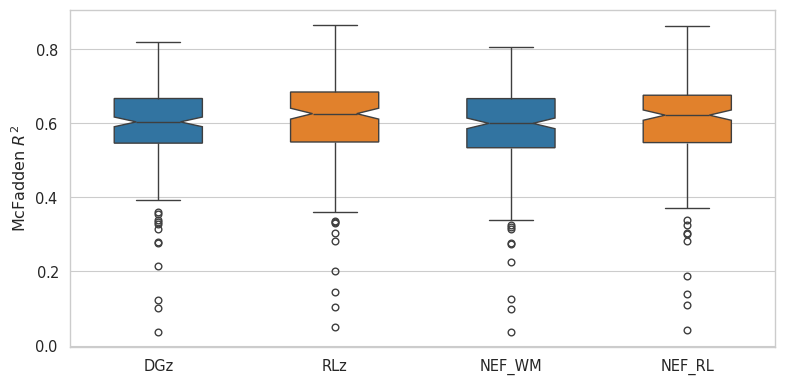

In [48]:
with sns.axes_style("whitegrid"):  # This enables gridlines
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
    sns.boxplot(combined, x='type', y='McFadden R2', hue='type', ax=ax, palette=palette[:2], notch=True, width=0.5)
    sns.boxplot(combined_nef, x='type', y='McFadden R2', hue='type', ax=ax, palette=palette[:2], notch=True, width=0.5)
    ax.set(xlabel=None, ylabel=r'McFadden $R^2$') 
    plt.tight_layout()
    fig.savefig("plots/math_vs_nef.jpg", dpi=600)
    # fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,6), sharex=True, sharey='row')
    # sns.boxplot(combined, x='type', y='NLL', hue='type', ax=axes[0], palette=palette[:2], notch=True, width=0.5)
    # sns.boxplot(combined_nef, x='type', y='NLL', hue='type', ax=axes[0], palette=palette[:2], notch=True, width=0.5)
    # sns.boxplot(combined, x='type', y='McFadden R2', hue='type', ax=axes[1], palette=palette[:2], notch=True, width=0.5)
    # sns.boxplot(combined_nef, x='type', y='McFadden R2', hue='type', ax=axes[1], palette=palette[:2], notch=True, width=0.5)
    # axes[0].set(xlabel=None, ylabel='Negative Log Likelihood', ylim=(0,120)) 
    # axes[1].set(xlabel=None, ylabel=r'McFadden $R^2$') 
    # plt.tight_layout()
    # fig.savefig("plots/math_vs_nef.jpg", dpi=600)

## Compare fitted z and inv_temp of (DGzk, RLz, NEF_WM, NEF_RL)

In [49]:
dgz = pd.read_pickle("data/DGz_jan13_params.pkl")
rlz = pd.read_pickle("data/RLz_jan9b_params.pkl")
combined = pd.concat([dgz, rlz], ignore_index=True)

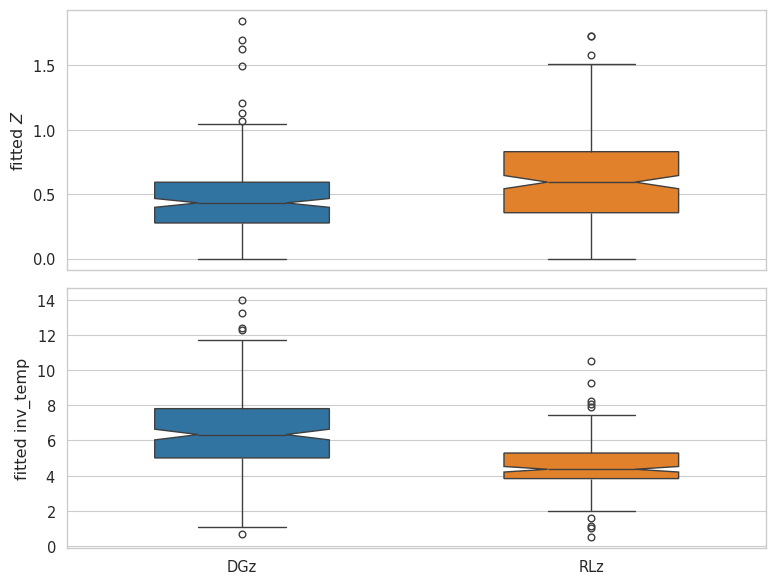

In [50]:
with sns.axes_style("whitegrid"):  # This enables gridlines
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,6), sharex=True, sharey='row')
    sns.boxplot(combined, x='type', y='z', hue='type', ax=axes[0], palette=palette[:2], notch=True, width=0.5)
    sns.boxplot(combined, x='type', y='inv_temp', hue='type', ax=axes[1], palette=palette[:2], notch=True, width=0.5)
    axes[0].set(xlabel=None, ylabel=r'fitted $Z$') 
    axes[1].set(xlabel=None, ylabel=r'fitted inv_temp') 
    plt.tight_layout()
    fig.savefig("plots/math_vs_nef_params.jpg", dpi=600)

## Compare expectation dynamics of (DGzk, RLz, NEF_WM, NEF_RL)

In [51]:
columns = ['type', 'sid', 'trial', 'stage', 'neighbors', 'expectation', 'delta E', 'sum delta E', 'growth E', 'sum growth E', 'action', 'delta A', 'sum switches']
dfs = []
rerunfiles = ['data/DGz_jan13_dynamics.pkl', 'data/RLz_jan9b_reruns.pkl', 'data/NEF_WM_jan13_dynamics.pkl', 'data/NEF_RL_jan9b_reruns.pkl']
human = pd.read_pickle(f"data/human.pkl")
sids = human['sid'].unique()
model_types = ['DGz', 'RLz', 'NEF_WM', 'NEF_RL']
for sid in sids:
    trials = human.query("sid==@sid")['trial'].unique()
    for m, model_type in enumerate(model_types):
        for trial in trials:
            E_old = 0
            A_old = 0
            sum_switches = 0
            sum_delta_E = 0
            sum_growth_E = 0
            neighbors = len(human.query("sid==@sid & trial==@trial & stage==1")['who'].unique())
            for stage in range(4):
                subdata = pd.read_pickle(rerunfiles[m]).query("sid==@sid & trial==@trial & stage==@stage")
                A = subdata['action'].unique()[0]
                E = subdata['expectation'].unique()[0]
                delta_E = np.abs(E - E_old)
                # more likely to switch if expectation moves towards zero: likelihood depends on magnitude of shift
                # negative values = unlikely to switch, postive values = likely to switch
                growth_E = -delta_E if (np.sign(E)==np.sign(E_old) and np.abs(E)>np.abs(E_old)) else delta_E  
                delta_A = 0 if A==A_old else 1
                sum_delta_E += delta_E
                sum_growth_E += growth_E
                if stage>0 and delta_A==1:
                    sum_switches += 1
                dfs.append(pd.DataFrame([[
                    model_type, sid, trial, stage, neighbors, E, delta_E, sum_delta_E, growth_E, sum_growth_E, A, delta_A, sum_switches
                ]], columns=columns))
                E_old = E
                A_old = A
dynamics = pd.concat(dfs, ignore_index=True)

In [52]:
columns = ['type', 'sid', 'trial', 'stage', 'neighbors', 'expectation', 'delta E', 'growth E', 'action', 'delta A', 'sum switches']
dfs = []
human = pd.read_pickle(f"data/human.pkl")
sids = human['sid'].unique()
for sid in sids:
    trials = human.query("sid==@sid")['trial'].unique()
    for trial in trials:
        action_old = 0
        sum_switches = 0
        neighbors = len(human.query("sid==@sid & trial==@trial & stage==1")['who'].unique())
        for stage in range(4):
            action = human.query("sid==@sid & trial==@trial & stage==@stage")['action'].unique()[0]
            delta_A = 0 if action==action_old else 1
            if stage>0 and delta_A==1:
                sum_switches += 1
            dfs.append(pd.DataFrame([['human', sid, trial, stage, neighbors, None, None, None, action, delta_A, sum_switches]], columns=columns))
            action_old = action
dynamics_human = pd.concat(dfs, ignore_index=True)

In [53]:
combined = pd.concat([dynamics, dynamics_human])

/tmp/ipykernel_149456/3986656787.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat([dynamics, dynamics_human])


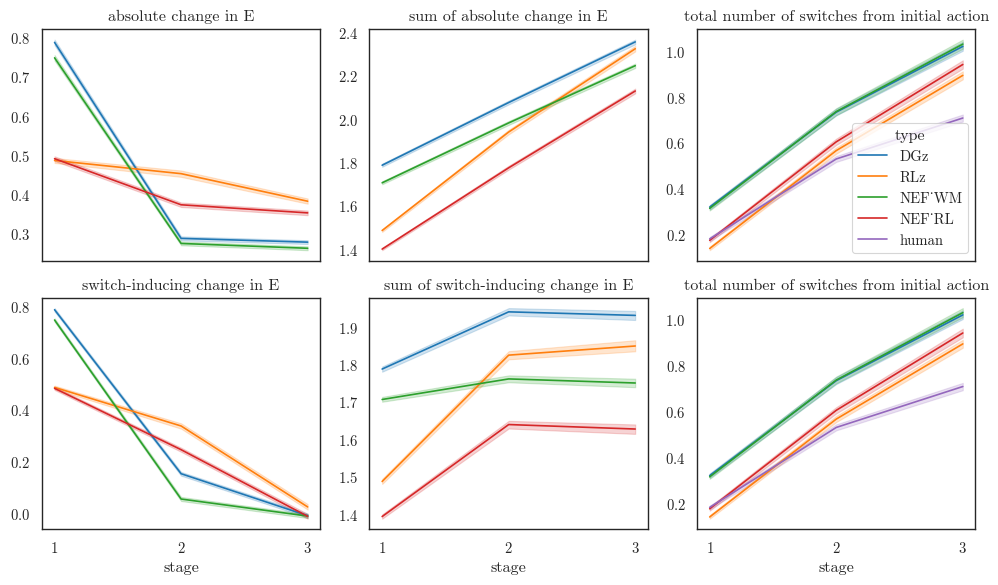

In [54]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,6), sharex=True)
sns.lineplot(data=combined.query("type!='human' & stage>0"), x='stage', y='delta E', hue='type', palette=palette[:4], ax=axes[0][0])
sns.lineplot(data=combined.query("type!='human' & stage>0"), x='stage', y='sum delta E', hue='type', palette=palette[:4], ax=axes[0][1])
sns.lineplot(data=combined.query("type!='human' & stage>0"), x='stage', y='growth E', hue='type', palette=palette[:4], ax=axes[1][0])
sns.lineplot(data=combined.query("type!='human' & stage>0"), x='stage', y='sum growth E', hue='type', palette=palette[:4], ax=axes[1][1])
sns.lineplot(data=combined.query("stage>0"), x='stage', y='sum switches', hue='type', palette=palette[:5], ax=axes[0][2])
sns.lineplot(data=combined.query("stage>0"), x='stage', y='sum switches', hue='type', palette=palette[:5], ax=axes[1][2])
axes[0][0].set(ylabel="", title='absolute change in E', xticks=[1,2,3])
axes[0][1].set(ylabel="", title='sum of absolute change in E', xticks=[1,2,3])
axes[0][2].set(ylabel="", title='total number of switches from initial action', xticks=[1,2,3])
axes[1][0].set(ylabel="", title='switch-inducing change in E', xticks=[1,2,3])
axes[1][1].set(ylabel="", title='sum of switch-inducing change in E', xticks=[1,2,3])
axes[1][2].set(ylabel="", title='total number of switches from initial action', xticks=[1,2,3])
axes[0][0].get_legend().remove()
axes[0][1].get_legend().remove()
# axes[0][2].get_legend().remove()
axes[1][0].get_legend().remove()
axes[1][1].get_legend().remove()
axes[1][2].get_legend().remove()
plt.tight_layout()
fig.savefig("plots/delta_expectation_and_action.jpg")
plt.show()

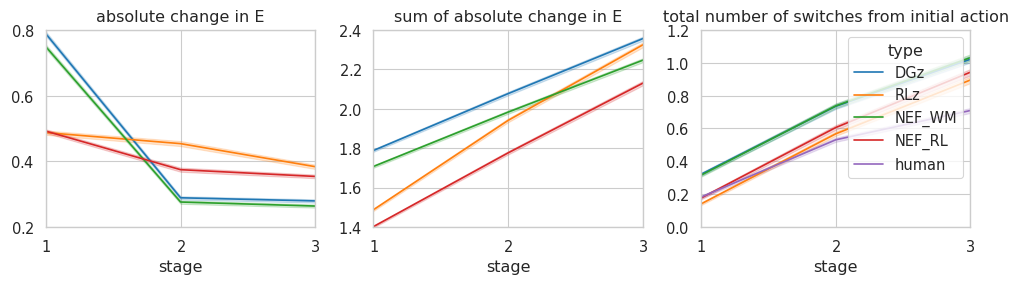

In [55]:
with sns.axes_style("whitegrid"):  # This enables gridlines
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,3), sharex=True)
    sns.lineplot(data=combined.query("type!='human' & stage>0"), x='stage', y='delta E', hue='type', palette=palette[:4], ax=axes[0])
    sns.lineplot(data=combined.query("type!='human' & stage>0"), x='stage', y='sum delta E', hue='type', palette=palette[:4], ax=axes[1])
    sns.lineplot(data=combined.query("stage>0"), x='stage', y='sum switches', hue='type', palette=palette[:5], ax=axes[2])
    axes[0].set(xlim=[1, 3], ylabel="", title='absolute change in E', xticks=[1,2,3], ylim=[0.2,0.8])
    axes[1].set(ylabel="", title='sum of absolute change in E', xticks=[1,2,3], ylim=[1.4, 2.4])
    axes[2].set(ylabel="", title='total number of switches from initial action', xticks=[1,2,3], ylim=[0,1.2])
    axes[0].get_legend().remove()
    axes[1].get_legend().remove()
    # axes[0][2].get_legend().remove()
    plt.tight_layout()
    fig.savefig("plots/delta_expectation_and_action.jpg")
    plt.show()

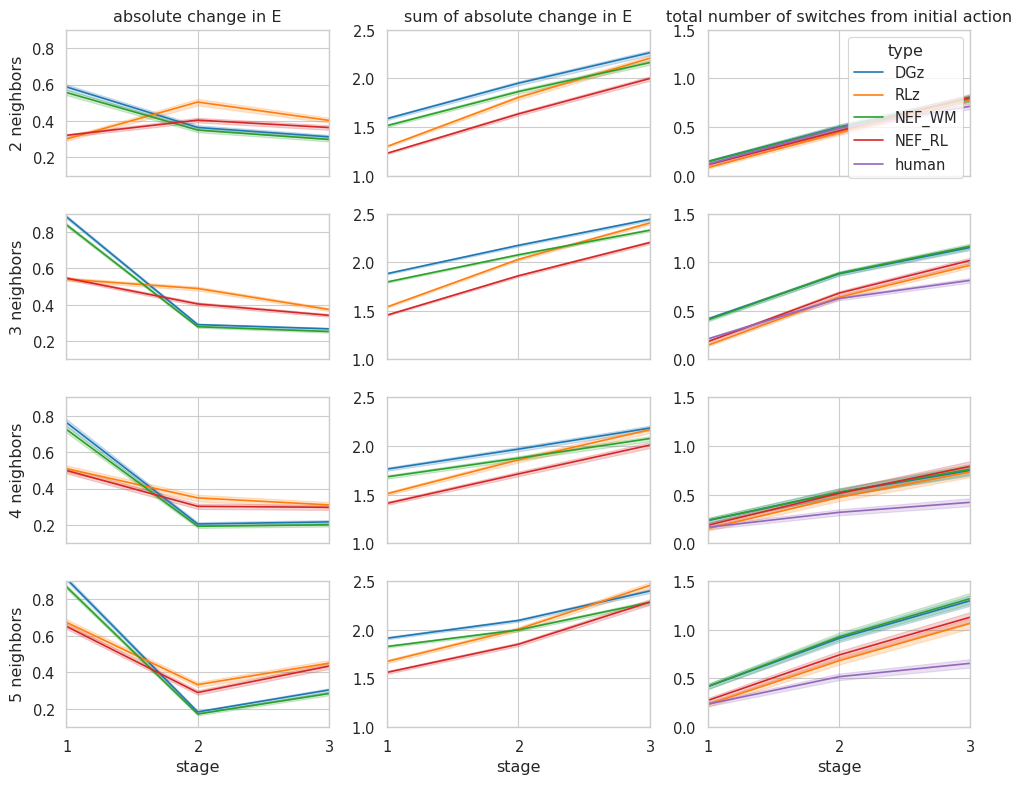

In [56]:
with sns.axes_style("whitegrid"):  # This enables gridlines
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10,8), sharex=True, sharey='col')
    for n in range(2,6):
        sns.lineplot(data=combined.query("type!='human' & stage>0 & neighbors==@n"), x='stage', y='delta E', hue='type', palette=palette[:4], ax=axes[n-2][0])
        sns.lineplot(data=combined.query("type!='human' & stage>0 & neighbors==@n"), x='stage', y='sum delta E', hue='type', palette=palette[:4], ax=axes[n-2][1])
        sns.lineplot(data=combined.query("stage>0 & neighbors==@n"), x='stage', y='sum switches', hue='type', palette=palette[:5], ax=axes[n-2][2])
        
    for n in range(2,6):
        if n==2:
            axes[n-2][0].set(xlim=[1, 3], ylabel="", title='absolute change in E', xticks=[1,2,3], ylim=[0.1,0.9])
            axes[n-2][1].set(ylabel="", title='sum of absolute change in E', xticks=[1,2,3], ylim=[1.0, 2.5])
            axes[n-2][2].set(ylabel="", title='total number of switches from initial action', xticks=[1,2,3], ylim=[0,1.5])
        axes[n-2][0].set(xlim=[1, 3], ylabel=f"{n} neighbors", xticks=[1,2,3], ylim=[0.1,0.9])
        axes[n-2][1].set(ylabel="", xticks=[1,2,3], ylim=[1.0, 2.5])
        axes[n-2][2].set(ylabel="", xticks=[1,2,3], ylim=[0,1.5])
        axes[n-2][0].get_legend().remove()
        axes[n-2][1].get_legend().remove()
        if n>2:
            axes[n-2][2].get_legend().remove()
    plt.tight_layout()
    fig.savefig("plots/delta_expectation_and_action_neighbors.jpg")
    plt.show()

## Compare Log-Likelihood and McFadden R-squared across all subjects and all models

In [7]:
nonnef = pd.read_pickle("data/all_scipy2_performance.pkl").query("type not in ['DGrd', 'DGrds', 'DGrdp', 'DGrdpz', 'NEF-WM', 'NEF-RL']")

In [8]:
nefwm = pd.read_pickle("data/NEF-WM_loadzk_performance.pkl")
nefrl = pd.read_pickle("data/NEF-RL_loadzk_performance.pkl")

In [9]:
combined = pd.concat([nonnef, nefwm, nefrl], ignore_index=True)

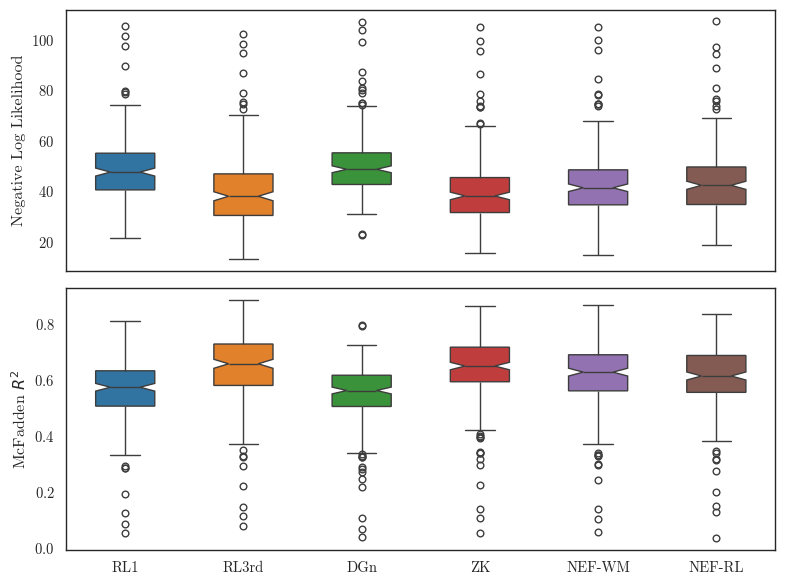

In [10]:
fig, axes = plt.subplots(nrows=2,ncols=1,figsize=(8,6), sharex=True)
bins = np.arange(0, 150, 5)
types = combined['type'].unique()
sns.boxplot(combined, x='type', y='NLL', hue='type', ax=axes[0], palette=palette[:len(types)],
           notch=True, width=0.5)
sns.boxplot(combined, x='type', y='McFadden R2', hue='type', ax=axes[1], palette=palette[:len(types)],
           notch=True, width=0.5)
axes[0].set(xlabel=None, ylabel='Negative Log Likelihood') 
axes[1].set(xlabel=None, ylabel=r'McFadden $R^2$') 
plt.tight_layout()
fig.savefig("plots/fitted_scipy.png", dpi=600)

## Calculate the frequency that each model produces the best fit across all subjects

In [11]:
sids = combined['sid'].unique()
types = combined['type'].unique()

freqs = {}
for model_type in types:
    freqs[model_type] = {'NLL': 0, 'R2': 0}

for sid in sids:
    subdata = combined.query("sid==@sid")
    # Find the index of the row with the minimum value in column 'NLL' or 'McFadden R2'
    nll_min_idx = subdata['NLL'].idxmin()
    r2_min_idx = subdata['McFadden R2'].idxmax()
    # Retrieve the row corresponding to this index
    nll_min_row = subdata.loc[nll_min_idx]
    r2_min_row = subdata.loc[r2_min_idx]
    # Retrieve the model type
    nll_best_type = nll_min_row['type']
    r2_best_type = r2_min_row['type']
    freqs[nll_best_type]['NLL'] += 1
    freqs[r2_best_type]['R2'] += 1

dfs = []
columns = ['type', 'freq best NLL', 'freq best R2']
for model_type in types:
    df = pd.DataFrame([[model_type, freqs[model_type]['NLL']/len(sids), freqs[model_type]['R2']/len(sids)]], columns=columns)
    dfs.append(df)
freq_best_data = pd.concat(dfs, ignore_index=True)
freq_best_data.to_pickle(f"data/freq_best_data.pkl")

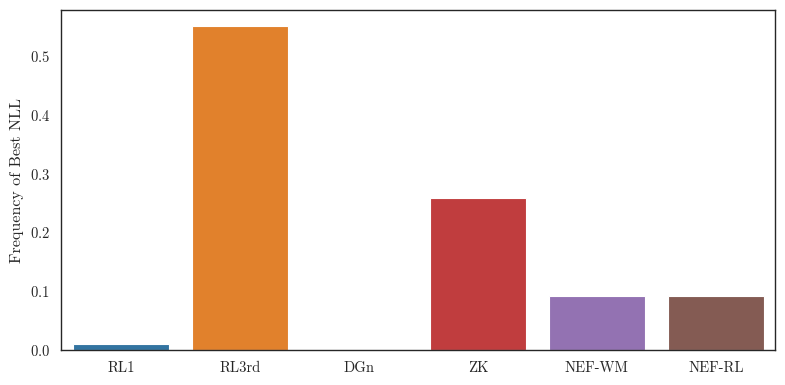

In [12]:
order = freq_best_data['type'].unique()
fig, ax = plt.subplots(1,1,figsize=(8,4))
sns.barplot(data=freq_best_data, x='type', y='freq best NLL', hue='type',
             ax=ax, order=order, hue_order=order, palette=palette[:len(order)])
ax.set(xlabel=None, ylabel='Frequency of Best NLL')
plt.tight_layout()
fig.savefig(f"plots/frequency_best.png", dpi=600)

## Trial lag analysis

In [48]:
def fit_lag(combined):
    GLMs = {}
    for model_type in combined['type'].unique():
        data = combined.query("type==@model_type")
        if data.size==0: continue
        GLMs[model_type] = {}
        for obs_per_stage in range(2,6):
            print(f"{model_type}, {obs_per_stage}")
            curr_stage_X = []
            curr_stage_Y = []
        
            idx_stage = 3
            lags = obs_per_stage*idx_stage
            seq_len = obs_per_stage*idx_stage+1
        
            for idx_subj in np.unique(data['sid'].values):
                for idx_trial in np.unique(data.loc[(data['sid']==idx_subj)]['trial']):
                    curr_subj_trial_data = data.loc[(data['sid']==idx_subj)  & (data['trial']==idx_trial) & (data['stage']<=idx_stage)][['color', 'RD']]
        
                    curr_subj_trial_X = []
                    data_len = len(curr_subj_trial_data)
        
                    if data_len!=seq_len:
                        continue
        
                    # for idx_lag in np.random.permutation(lags):            
                    for idx_lag in range(lags):
                        curr_subj_trial_X.append([
                            curr_subj_trial_data['color'].iloc[data_len-idx_lag-1], 
                            # curr_subj_trial_data['obs'].iloc[data_len-idx_lag-1]*curr_subj_trial_data['RD'].iloc[data_len-idx_lag-1]
                        ])
        
                    curr_stage_X.append(np.concatenate(curr_subj_trial_X))
                    curr_stage_Y.append([
                        data.loc[(data['sid']==idx_subj) & (data['stage']==idx_stage) & (data['trial']==idx_trial)]['action'].median()
                    ]) # +- 1
        
            curr_stage_X = np.stack(curr_stage_X)
            curr_stage_X = sm.add_constant(curr_stage_X)
            curr_stage_Y = (np.array(curr_stage_Y)+1)/2
        
            # print(curr_stage_X.shape)
        
            mdl = sm.GLM(curr_stage_Y, curr_stage_X, family=sm.families.Binomial()).fit()
            GLMs[model_type][obs_per_stage] = {'lags': np.arange(lags), 'params': mdl.params[1:], 'bse': mdl.bse[1:]}

    return GLMs
    #         plt.errorbar(np.arange(lags), mdl.params[1:], mdl.bse[1:], label=obs_per_stage)
    
    
    # plt.legend()
    # plt.xlabel('Trials lag')
    # sns.despine()

In [ ]:
human = pd.read_pickle(f"data/human.pkl")
human['type'] = 'human'
nonnef = pd.read_pickle("data/all_scipy2_reruns.pkl").query("type not in ['DGrd', 'DGrds', 'DGrdp', 'DGrdpz', 'NEF-WM', 'NEF-RL']")
nefwm = pd.read_pickle("data/NEF-WM_loadzk_reruns.pkl")
nefrl = pd.read_pickle("data/NEF-RL_loadzk_reruns.pkl")
reruns = pd.concat([human, nonnef, nefwm, nefrl], ignore_index=True)
# print(reruns)
GLMs = fit_lag(reruns)

In [ ]:
model_types = GLMs.keys()
obs_per_stage = range(2,6)
fig, axes = plt.subplots(nrows=len(model_types), ncols=len(obs_per_stage), figsize=(8,12), sharex='col', sharey='row')
for m, model_type in enumerate(model_types):
    for o, obs in enumerate(obs_per_stage):
        xs = GLMs[model_type][obs]['lags']
        ys = GLMs[model_type][obs]['params']
        es = GLMs[model_type][obs]['bse']
        axes[m][o].errorbar(xs, ys, es, label=model_type, color=palette[m])
        axes[m][o].legend()
        if m==0:
            axes[m][o].set(title=f"{obs} observations per stage")
        if m==len(model_types)-1:
            axes[m][o].set(xlabel='Trial Lag', xticks=np.arange(0, 3*obs+1))
    axes[m][0].set(ylabel=model_type)
axes[0][0].set(ylim=[-0.2,1.6])
plt.tight_layout()
fig.savefig(f"plots/trial_lag.png", dpi=600)

### My method for calculating influence of lag

In [9]:
def measure_lag(data):
    sids = data['sid'].unique()
    model_types = data['type'].unique()
    columns = ['type', 'sid', 'trial', 'neighbors', 'stage', 'lag', 'action equals lagged observation']
    dfs = []
    for model_type in model_types:
        for sid in sids:
            print('type', model_type, 'sid', sid)
            trials = data.query('type==@model_type & sid==@sid')['trial'].unique()
            for trial in trials:
                subdata = data.query("type==@model_type & trial==@trial and sid==@sid")
                stages = subdata['stage'].unique()
                neighbors = len(subdata['who'].unique()) - 1
                # print(subdata)
                for stage in stages:
                    observations = subdata.query("stage<=@stage")['color'].to_numpy()
                    action = subdata.query("stage==@stage")['action'].unique()[0]
                    # print('stage', stage, 'action', action, 'obs', observations)
                    for o in range(len(observations)):
                        lag = o+1
                        lagged_obs = observations[-lag]
                        action_eq_lagged_obs = 1 if action==lagged_obs else 0
                        # print(o, lag, lagged_obs)
                        df = pd.DataFrame([[
                            model_type,
                            sid,
                            trial,
                            neighbors,
                            stage,
                            lag,
                            action_eq_lagged_obs
                        ]], columns=columns)
                        dfs.append(df)
                # lag_data = pd.concat(dfs, ignore_index=True)
                # print(lag_data)
                # raise
    lag_data = pd.concat(dfs, ignore_index=True)
    # lag_data.to_pickle(f"data/lagged_reruns.pkl")
    return lag_data

In [ ]:
human = pd.read_pickle(f"data/human.pkl")
human['type'] = 'human'
nonnef = pd.read_pickle("data/all_scipy2_reruns.pkl").query("type not in ['DGrd', 'DGrds', 'DGrdp', 'DGrdpz', 'NEF-WM', 'NEF-RL']")
# nefwm = pd.read_pickle("data/NEF-WM_loadzk_reruns.pkl")
# nefrl = pd.read_pickle("data/NEF-RL_loadzk_reruns.pkl")
reruns = pd.concat([human, nonnef], ignore_index=True)
lag_data = measure_lag(reruns)

In [2]:
# fig = sns.FacetGrid(lag_data, col="neighbors", sharex='col')
# fig.map_dataframe(sns.lineplot, x="lag", y='action equals lagged observation', hue='type', palette=palette[:1])

In [ ]:
# neighbors = lag_data['neighbors'].unique()
lag_data = pd.read_pickle(f"data/lagged_reruns.pkl")
neighbors = [1,2,3,4,5]  # 6
model_types = lag_data['type'].unique()

for stage in range(4):
    fig, axes = plt.subplots(ncols=len(neighbors), nrows=len(model_types),
                             figsize=(3*len(neighbors), 3*len(model_types)),
                             sharey=True, sharex='col')
    for mt, model_type in enumerate(model_types):
        for n, neighbor in enumerate(neighbors):
            print(model_type, neighbor)
            subdata = lag_data.query("stage==@stage & type==@model_type & neighbors==@neighbor")
            sample_size = subdata.query("lag==1").shape[0]
            sns.lineplot(data=subdata, x='lag', y='action equals lagged observation',
                         ax=axes[mt][n], color=palette[mt], label=f"sample size = {sample_size}")
            if stage>0:
                axes[mt][n].axvline(1*neighbor+0.5, color='k', lw=0.2)
            if stage>1:
                axes[mt][n].axvline(2*neighbor+0.5, color='k', lw=0.2)
            if stage>2:
                axes[mt][n].axvline(3*neighbor+0.5, color='k', lw=0.2)
            axes[0][n].set(title=f"{neighbor} neighbors")
        axes[mt][0].set(ylabel=f"P(action = lagged obs)\n{model_type}")
    axes[mt][n].set(xticks=subdata['lag'].unique(), title=f"{neighbor} neighbors")
    plt.tight_layout()
    fig.savefig(f"plots/lag_stage{stage}.png", dpi=600)

stage 1 neighbor 1
stage 1 neighbor 2
stage 1 neighbor 3
stage 1 neighbor 4
stage 1 neighbor 5
stage 2 neighbor 1
stage 2 neighbor 2
stage 2 neighbor 3
stage 2 neighbor 4
stage 2 neighbor 5
stage 3 neighbor 1
stage 3 neighbor 2
stage 3 neighbor 3
stage 3 neighbor 4
stage 3 neighbor 5


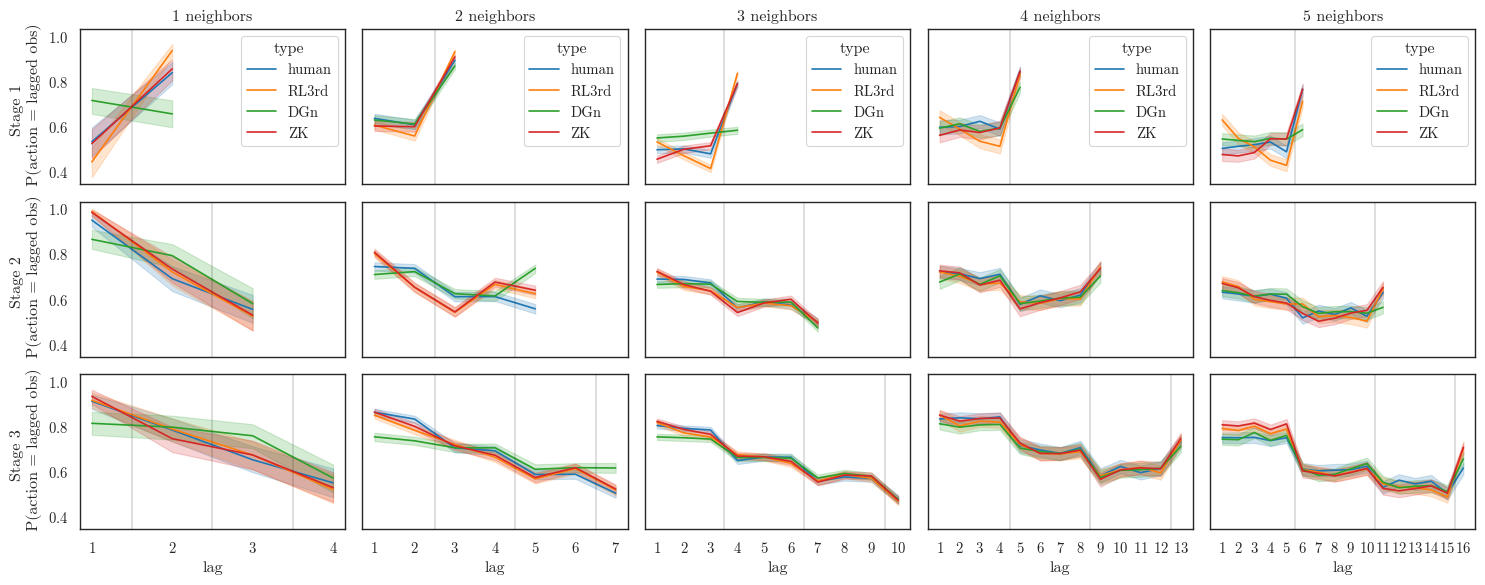

In [11]:
# neighbors = lag_data['neighbors'].unique()
lag_data = pd.read_pickle(f"data/lagged_reruns.pkl").query("type!='RL1'")
neighbors = [1,2,3,4,5]  # 6
model_types = lag_data['type'].unique()
fig, axes = plt.subplots(ncols=len(neighbors), nrows=3,
                         figsize=(3*len(neighbors), 2*3),
                         sharey=True, sharex='col')
for stage in range(1,4):
    for n, neighbor in enumerate(neighbors):
        print('stage', stage, 'neighbor', neighbor)
        subdata = lag_data.query("stage==@stage & neighbors==@neighbor")
        sns.lineplot(data=subdata, x='lag', y='action equals lagged observation', hue='type',
                     ax=axes[stage-1][n], palette=palette[:len(model_types)])
        if stage>0:
            axes[stage-1][n].axvline(1*neighbor+0.5, color='k', lw=0.2)
        if stage>1:
            axes[stage-1][n].axvline(2*neighbor+0.5, color='k', lw=0.2)
        if stage>2:
            axes[stage-1][n].axvline(3*neighbor+0.5, color='k', lw=0.2)

for stage in range(1,4):
    for n, neighbor in enumerate(neighbors):
        subdata = lag_data.query("stage==@stage & neighbors==@neighbor")
        if stage>1:
            axes[stage-1][n].get_legend().remove()
        axes[stage-1][n].set(xticks=subdata['lag'].unique())
        axes[0][n].set(title=f"{neighbor} neighbors")
    axes[stage-1][0].set(ylabel=f"Stage {stage} \n P(action = lagged obs)")
plt.tight_layout()
fig.savefig(f"plots/lag_per_stage.png", dpi=600)

## DGn vs NEF-WM (z=0, k=1)

type human sid 1
type human sid 2
type human sid 3
type human sid 4
type human sid 5
type human sid 6
type human sid 7
type human sid 8
type human sid 9
type human sid 10
type human sid 11
type human sid 12
type human sid 13
type human sid 14
type human sid 15
type human sid 16
type human sid 18
type human sid 19
type human sid 20
type human sid 21
type human sid 23
type human sid 24
type human sid 25
type human sid 26
type human sid 27
type human sid 28
type human sid 29
type human sid 30
type human sid 31
type human sid 32
type human sid 33
type human sid 34
type human sid 35
type human sid 36
type human sid 38
type human sid 39
type human sid 40
type human sid 41
type human sid 42
type human sid 43
type human sid 44
type human sid 45
type human sid 46
type human sid 47
type human sid 48
type human sid 49
type human sid 57
type human sid 58
type human sid 59
type human sid 60
type human sid 61
type human sid 62
type human sid 63
type human sid 64
type human sid 65
type human sid 66
t

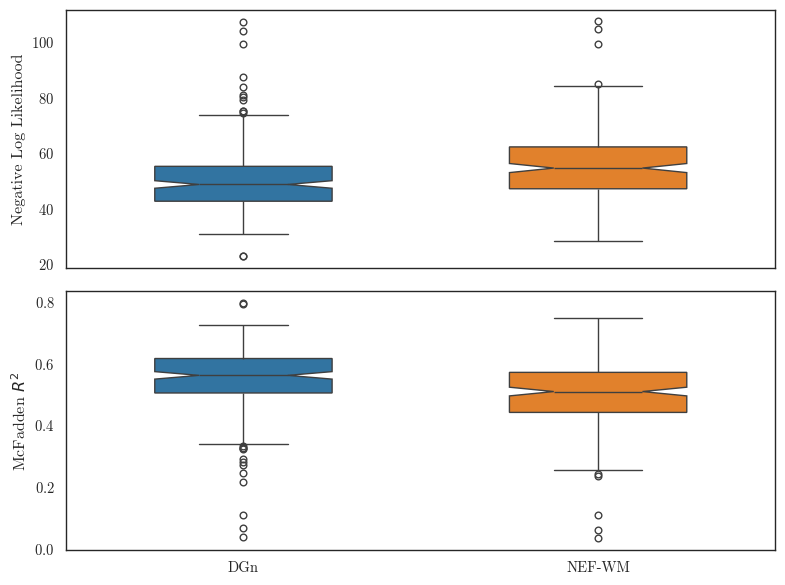

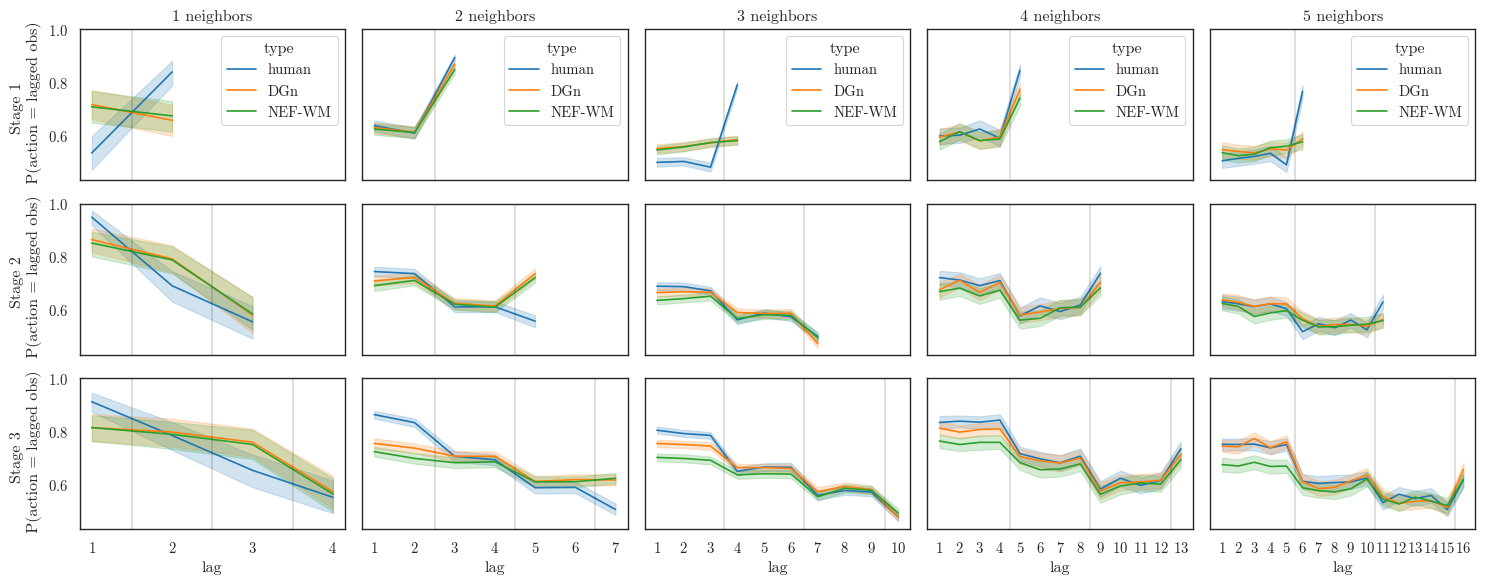

In [10]:
nefwm = pd.read_pickle("data/NEF-WM_z0k1_performance.pkl")
human_and_dgn = pd.read_pickle("data/all_scipy2_performance.pkl").query("type in ['human', 'DGn']")
combined = pd.concat([human_and_dgn, nefwm], ignore_index=True)
# print(combined)

fig, axes = plt.subplots(nrows=2,ncols=1,figsize=(8,6), sharex=True)
bins = np.arange(0, 150, 5)
types = combined['type'].unique()
sns.boxplot(combined, x='type', y='NLL', hue='type', ax=axes[0], palette=palette[:len(types)],
           notch=True, width=0.5)
sns.boxplot(combined, x='type', y='McFadden R2', hue='type', ax=axes[1], palette=palette[:len(types)],
           notch=True, width=0.5)
axes[0].set(xlabel=None, ylabel='Negative Log Likelihood') 
axes[1].set(xlabel=None, ylabel=r'McFadden $R^2$') 
plt.tight_layout()
fig.savefig("plots/dgn_vs_nefwm.png", dpi=600)


human = pd.read_pickle(f"data/human.pkl")
human['type'] = 'human'
dgn = pd.read_pickle("data/all_scipy2_reruns.pkl").query("type=='DGn'")
nefwm = pd.read_pickle("data/NEF-WM_z0k1_reruns.pkl")
reruns = pd.concat([human, dgn, nefwm], ignore_index=True)
lag_data = measure_lag(reruns)

neighbors = [1,2,3,4,5]  # 6
model_types = lag_data['type'].unique()
fig, axes = plt.subplots(ncols=len(neighbors), nrows=3,
                         figsize=(3*len(neighbors), 2*3),
                         sharey=True, sharex='col')
for stage in range(1,4):
    for n, neighbor in enumerate(neighbors):
        print('stage', stage, 'neighbor', neighbor)
        subdata = lag_data.query("stage==@stage & neighbors==@neighbor")
        sns.lineplot(data=subdata, x='lag', y='action equals lagged observation', hue='type',
                     ax=axes[stage-1][n], palette=palette[:len(model_types)])
        if stage>0:
            axes[stage-1][n].axvline(1*neighbor+0.5, color='k', lw=0.2)
        if stage>1:
            axes[stage-1][n].axvline(2*neighbor+0.5, color='k', lw=0.2)
        if stage>2:
            axes[stage-1][n].axvline(3*neighbor+0.5, color='k', lw=0.2)

for stage in range(1,4):
    for n, neighbor in enumerate(neighbors):
        subdata = lag_data.query("stage==@stage & neighbors==@neighbor")
        if stage>1:
            axes[stage-1][n].get_legend().remove()
        axes[stage-1][n].set(xticks=subdata['lag'].unique())
        axes[0][n].set(title=f"{neighbor} neighbors")
    axes[stage-1][0].set(ylabel=f"Stage {stage} \n P(action = lagged obs)")
plt.tight_layout()
fig.savefig(f"plots/lag_per_stage.png", dpi=600)

## Estimate influence of most recent observation(s) on choice

In [77]:
def measure_influence(data):
    sids = data['sid'].unique()
    model_types = data['type'].unique()
    columns = ['type', 'sid', 'trial', 'neighbors', 'stage', 'last obs', 'mean of stage obs', 'action']
    dfs = []
    for model_type in model_types:
        for sid in sids:
            print('type', model_type, 'sid', sid)
            trials = data.query('type==@model_type & sid==@sid')['trial'].unique()
            for trial in trials:
                subdata = data.query("type==@model_type & trial==@trial and sid==@sid")
                stages = subdata['stage'].unique()
                neighbors = len(subdata['who'].unique()) - 1
                for stage in stages:
                    observations = subdata.query("stage==@stage")['color'].to_numpy()
                    action = subdata.query("stage==@stage")['action'].unique()[0]
                    print(stage, observations, action)
                    df = pd.DataFrame([[
                        model_type,
                        sid,
                        trial,
                        neighbors,
                        stage,
                        observations[-1],
                        np.mean(observations),
                        action
                    ]], columns=columns)
                    dfs.append(df)
    influence_data = pd.concat(dfs, ignore_index=True)
    # influence_data.to_pickle(f"data/lagged_reruns.pkl")
    return influence_data

In [ ]:
dgzk = pd.read_pickle('data/ZK_dec11_reruns.pkl')
rlz = pd.read_pickle('data/RLz_jan7_reruns.pkl')
human = pd.read_pickle(f"data/human.pkl")
human['type'] = 'human'
reruns = pd.concat([human, dgzk, rlz], ignore_index=True)
influence_data = measure_influence(reruns)

In [ ]:
influence_data

In [88]:
subdata = influence_data.query("neighbors==3")

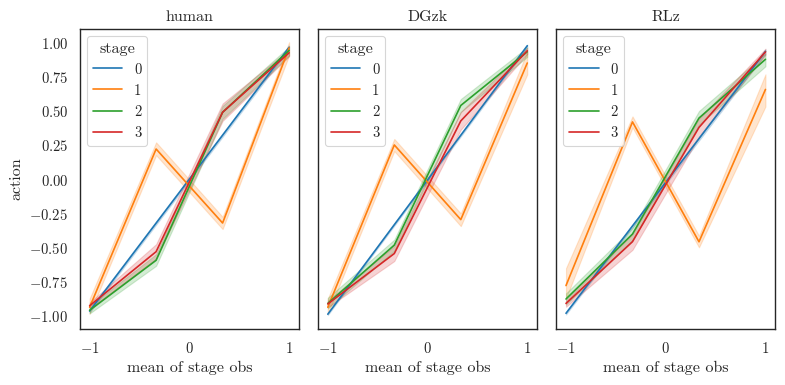

In [90]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(8, 4))
sns.lineplot(data=subdata.query("type=='human'"), x='mean of stage obs', y='action', hue='stage', palette=palette[:4], ax=axes[0])
sns.lineplot(data=subdata.query("type=='ZK'"), x='mean of stage obs', y='action', hue='stage', palette=palette[:4], ax=axes[1])
sns.lineplot(data=subdata.query("type=='RLz'"), x='mean of stage obs', y='action', hue='stage', palette=palette[:4], ax=axes[2])
axes[0].set(title='human')
axes[1].set(title='DGzk')
axes[2].set(title='RLz')
plt.tight_layout()
plt.show()

## Regress neural activities (error, weight) with external variables (aPE, RD)

In [2]:
act_data = activity_RL(1, 0.31, [3,0.25,0.25,0.25])

sid 1, trial 1
sid 1, trial 2
sid 1, trial 3
sid 1, trial 4
sid 1, trial 5


In [3]:
act_data

,type,sid,trial,stage,tidx,aPE,RD,error activity,weight activity
0,NEF_RL,1,1,0,200,0.918922,0.00000,129.196140,91.793255
1,NEF_RL,1,1,1,1200,1.541786,0.00000,104.098653,86.459572
2,NEF_RL,1,1,1,2200,1.205255,0.00000,92.029020,86.615990
3,NEF_RL,1,1,1,3200,0.955679,0.00000,92.074588,86.409190
4,NEF_RL,1,1,2,4200,1.224522,0.23077,95.876941,86.580860
5,NEF_RL,1,1,2,5200,1.007386,0.30769,95.008655,86.500802
6,NEF_RL,1,1,2,6200,1.245527,0.23077,96.415035,86.799514
7,NEF_RL,1,1,3,7200,0.922931,0.30769,92.804842,86.792045
8,NEF_RL,1,1,3,8200,0.684199,0.23077,90.696808,86.488984
9,NEF_RL,1,1,3,9200,0.531321,0.23077,89.814035,86.457565


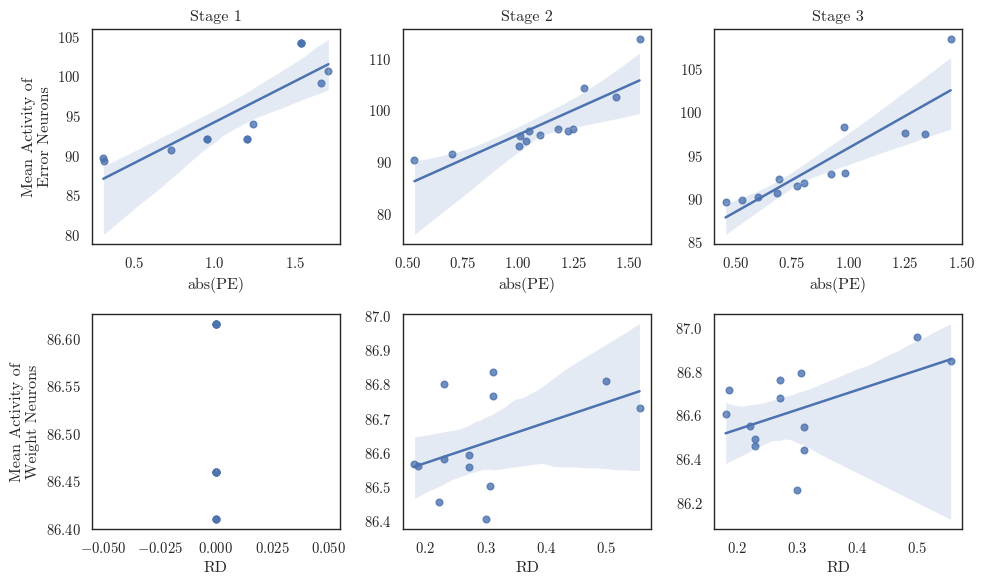

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
sns.regplot(data=act_data.query("stage==1"), x='aPE', y='error activity', ax=axes[0][0])
sns.regplot(data=act_data.query("stage==2"), x='aPE', y='error activity', ax=axes[0][1])
sns.regplot(data=act_data.query("stage==3"), x='aPE', y='error activity', ax=axes[0][2])
sns.regplot(data=act_data.query("stage==1"), x='RD', y='weight activity', ax=axes[1][0])
sns.regplot(data=act_data.query("stage==2"), x='RD', y='weight activity', ax=axes[1][1])
sns.regplot(data=act_data.query("stage==3"), x='RD', y='weight activity', ax=axes[1][2])
axes[0][0].set(title='Stage 1', xlabel='abs(PE)', ylabel='Mean Activity of\nError Neurons')
axes[0][1].set(title='Stage 2', xlabel='abs(PE)', ylabel=None)
axes[0][2].set(title='Stage 3', xlabel='abs(PE)', ylabel=None)
axes[1][0].set(xlabel='RD', ylabel='Mean Activity of\nWeight Neurons')
axes[1][1].set(xlabel='RD', ylabel=None)
axes[1][2].set(xlabel='RD', ylabel=None)
plt.tight_layout()
plt.show()